# *UNSUPERVISED LEARNING USING AUTOENCODER TO DETECT DEFAULT TRANSISTOR*

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
import torchvision.transforms.functional as F
import warnings
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.exceptions import UndefinedMetricWarning


In [ ]:
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

In [ ]:
def getting_pictures_path(path_folder):
  path_pictures = [os.path.join(path_folder, folder) for folder in os.listdir(path_folder) if not folder.startswith(".")]
  return path_pictures

pictures_path = getting_pictures_path("/content/drive/MyDrive/Dataset/transistor/train/good")
print(pictures_path)

['/content/drive/MyDrive/Dataset/transistor/train/good/028.png', '/content/drive/MyDrive/Dataset/transistor/train/good/031.png', '/content/drive/MyDrive/Dataset/transistor/train/good/022.png', '/content/drive/MyDrive/Dataset/transistor/train/good/036.png', '/content/drive/MyDrive/Dataset/transistor/train/good/007.png', '/content/drive/MyDrive/Dataset/transistor/train/good/000.png', '/content/drive/MyDrive/Dataset/transistor/train/good/008.png', '/content/drive/MyDrive/Dataset/transistor/train/good/032.png', '/content/drive/MyDrive/Dataset/transistor/train/good/001.png', '/content/drive/MyDrive/Dataset/transistor/train/good/003.png', '/content/drive/MyDrive/Dataset/transistor/train/good/025.png', '/content/drive/MyDrive/Dataset/transistor/train/good/038.png', '/content/drive/MyDrive/Dataset/transistor/train/good/006.png', '/content/drive/MyDrive/Dataset/transistor/train/good/020.png', '/content/drive/MyDrive/Dataset/transistor/train/good/034.png', '/content/drive/MyDrive/Dataset/transis

In [ ]:
transform = T.Compose(
    [
    T.Resize((256, 256)),
    T.RandomRotation(10),
    T.RandomHorizontalFlip(),
    T.ToTensor()
    ]
)

In [ ]:
class DatasetTrain(Dataset):

  def __init__(self, path_pictures, transform=transform):
    self.path_pictures = path_pictures
    self.transform = transform
    self.transform_label = T.Compose([
        T.Normalize(mean=[0.5], std=[0.5])
    ])
    self.size = (256, 256) # Added this line to define 'size'

  def __len__(self):
    return len(self.path_pictures)

  def __getitem__(self, idx):
    img_rgb = Image.open(self.path_pictures[idx]).convert("RGB")
    img_gray = Image.open(self.path_pictures[idx]).convert("L")

        # --- paramètres aléatoires partagés ---
    angle = random.uniform(-10, 10)
    flip = random.random() > 0.5

        # --- Resize ---
    img_rgb = F.resize(img_rgb, self.size)
    img_gray = F.resize(img_gray, self.size)

        # --- Rotation ---
    img_rgb = F.rotate(img_rgb, angle)
    img_gray = F.rotate(img_gray, angle)

        # --- Flip ---
    if flip:
        img_rgb = F.hflip(img_rgb)
        img_gray = F.hflip(img_gray)

        # --- ToTensor ---
    img_rgb = F.to_tensor(img_rgb)
    img_gray = F.to_tensor(img_gray)

        # --- Normalisation [-1, 1] ---


    img_gray = F.normalize(
            img_gray,
            mean=[0.5],
            std=[0.5]
        )

    return img_rgb, img_gray

dataset = DatasetTrain(pictures_path)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)
batch = next(iter(dataloader))


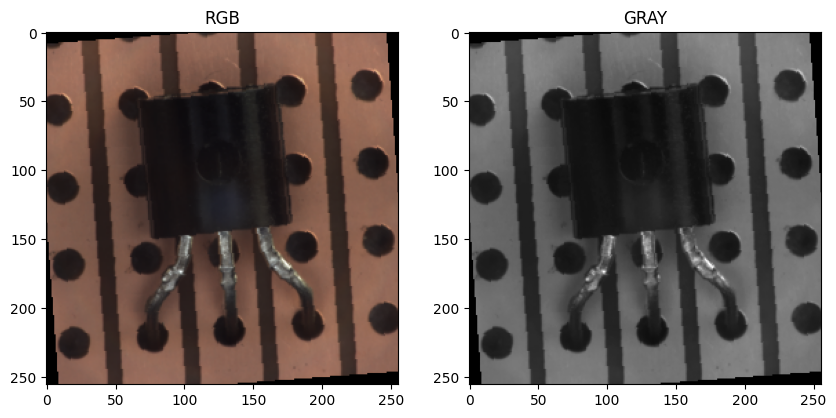

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(batch[0][0].permute(1, 2, 0))
ax[0].set_title("RGB")
ax[1].imshow(batch[1][0].permute(1, 2, 0), cmap = "gray")
ax[1].set_title("GRAY")
plt.show()

# Build the encoder layer

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)


class Encodeur(nn.Module):
    def __init__(self, in_channels=3, base_channels=16):
        super().__init__()

        self.enc1 = ConvBlock(in_channels, base_channels)
        self.enc2 = ConvBlock(base_channels, base_channels * 2)
        self.enc3 = ConvBlock(base_channels * 2, base_channels * 4)
        self.enc4 = ConvBlock(base_channels * 4, base_channels * 6)
        self.enc5 = ConvBlock(base_channels * 6, base_channels * 8)


        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.enc1(x)
        x = self.pool(x)

        x = self.enc2(x)
        x = self.pool(x)

        x = self.enc3(x)
        x = self.pool(x)

        x = self.enc4(x)
        x = self.pool(x)

        x = self.enc5(x)
        x = self.pool(x)

        return x



test de l'encodeur

In [ ]:
model = Encodeur(in_channels=3, base_channels=16)
model.eval()

x = torch.randn(1, 3, 256, 256)  # batch fictif
with torch.no_grad():
    y = model(x)

print("Output shape:", y.shape)

Output shape: torch.Size([1, 128, 8, 8])


build the decoder layer

In [ ]:
class Decodeur(nn.Module):
  def __init__(self, base_channels=16):
        super().__init__()

        self.up = nn.ConvTranspose2d(
            base_channels * 8, base_channels * 6,
            kernel_size=2, stride=2
        )
        self.dec = ConvBlock(base_channels * 6, base_channels * 6)

        self.up1 = nn.ConvTranspose2d(
            base_channels * 6, base_channels * 4,
            kernel_size=2, stride=2
        )
        self.dec1 = ConvBlock(base_channels * 4, base_channels * 4)

        self.up2 = nn.ConvTranspose2d(
            base_channels * 4, base_channels * 2,
            kernel_size=2, stride=2
        )
        self.dec2 = ConvBlock(base_channels * 2, base_channels * 2)

        self.up3 = nn.ConvTranspose2d(
            base_channels * 2, base_channels,
            kernel_size=2, stride=2
        )
        self.dec3 = ConvBlock(base_channels, base_channels)

        self.up4 = nn.ConvTranspose2d(
            base_channels, base_channels,
            kernel_size=2, stride=2
        )

        self.final_conv = nn.Conv2d(base_channels, 1, kernel_size=1)
        self.tanh = nn.Tanh()

  def forward(self, x):
        x = self.up(x)
        x = self.dec(x)

        x = self.up1(x)
        x = self.dec1(x)

        x = self.up2(x)
        x = self.dec2(x)

        x = self.up3(x)
        x = self.dec3(x)

        x = self.up4(x)
        x = self.final_conv(x)
        x = self.tanh(x)

        return x

In [ ]:
class AutoEncodeur(nn.Module):
    def __init__(self, in_channels=3, base_channels=16):
        super().__init__()
        self.encodeur = Encodeur(in_channels, base_channels)
        self.decodeur = Decodeur(base_channels)

    def forward(self, x):
        x = self.encodeur(x)
        x = self.decodeur(x)
        return x

# sanity check (sans dataset)

In [ ]:
model = AutoEncodeur(in_channels=3, base_channels=16)
model.eval()

x = torch.randn(1, 3, 256, 256)

with torch.no_grad():
    y = model(x)

print("Output shape:", y.shape)

Output shape: torch.Size([1, 1, 256, 256])


image check

In [ ]:
dataset = DatasetTrain(pictures_path)
loader = DataLoader(dataset, batch_size=1, shuffle=True)

images, targets = next(iter(loader))

print("Input:", images.shape)
print("Target:", targets.shape)

model.eval()
with torch.no_grad():
    output = model(images)

print("Output:", output.shape)
print("Min / Max output:", output.min().item(), output.max().item())
print("Min / Max target:", targets.min().item(), targets.max().item())

Input: torch.Size([1, 3, 256, 256])
Target: torch.Size([1, 1, 256, 256])
Output: torch.Size([1, 1, 256, 256])
Min / Max output: 0.23026522994041443 0.26459693908691406
Min / Max target: -1.0 1.0


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoEncodeur(in_channels=3, base_channels=16).to(device)

In [ ]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-4,
    betas=(0.9, 0.999)
)
criterion = nn.L1Loss()
batch_size = 16  # ou 16 si GPU OK
epochs = 50
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for imgs, targets in loader:
        # Move tensors to the appropriate device
        imgs = imgs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()

        outputs = model(imgs)
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1} - Loss: {running_loss/len(loader):.4f}")

Epoch 1 - Loss: 0.2210
Epoch 2 - Loss: 0.1070
Epoch 3 - Loss: 0.0857
Epoch 4 - Loss: 0.0745
Epoch 5 - Loss: 0.0696
Epoch 6 - Loss: 0.0661
Epoch 7 - Loss: 0.0649
Epoch 8 - Loss: 0.0629
Epoch 9 - Loss: 0.0611
Epoch 10 - Loss: 0.0601
Epoch 11 - Loss: 0.0585
Epoch 12 - Loss: 0.0575
Epoch 13 - Loss: 0.0562
Epoch 14 - Loss: 0.0555
Epoch 15 - Loss: 0.0545
Epoch 16 - Loss: 0.0546
Epoch 17 - Loss: 0.0531
Epoch 18 - Loss: 0.0532
Epoch 19 - Loss: 0.0524
Epoch 20 - Loss: 0.0516
Epoch 21 - Loss: 0.0514
Epoch 22 - Loss: 0.0515
Epoch 23 - Loss: 0.0505
Epoch 24 - Loss: 0.0495
Epoch 25 - Loss: 0.0497
Epoch 26 - Loss: 0.0490
Epoch 27 - Loss: 0.0489
Epoch 28 - Loss: 0.0484
Epoch 29 - Loss: 0.0486
Epoch 30 - Loss: 0.0481
Epoch 31 - Loss: 0.0479
Epoch 32 - Loss: 0.0475
Epoch 33 - Loss: 0.0470
Epoch 34 - Loss: 0.0470
Epoch 35 - Loss: 0.0464
Epoch 36 - Loss: 0.0468
Epoch 37 - Loss: 0.0459
Epoch 38 - Loss: 0.0458
Epoch 39 - Loss: 0.0460
Epoch 40 - Loss: 0.0457
Epoch 41 - Loss: 0.0451
Epoch 42 - Loss: 0.0450
E

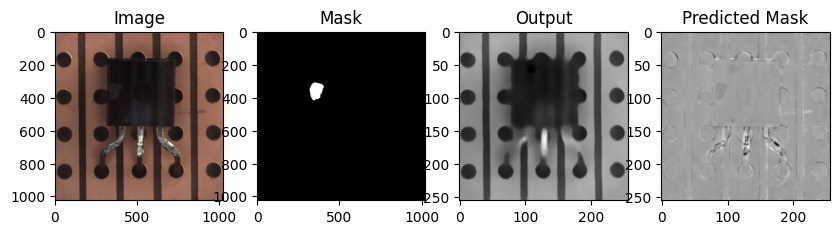

In [ ]:
IMG_SIZE = (256, 256)

path_image = "/content/drive/MyDrive/Dataset/transistor/test/damaged_case/002.png"
path_mask  = "/content/drive/MyDrive/Dataset/transistor/ground_truth/damaged_case/002_mask.png"

# -----------------------
# TRANSFORMS
# -----------------------
img_transform = T.Compose([
    T.Resize(IMG_SIZE),
    T.ToTensor()
])

mask_transform = T.Compose([
    T.Resize(IMG_SIZE),
    T.ToTensor()   # -> [0,1]
])

# -----------------------
# LOAD DATA
# -----------------------
image = Image.open(path_image).convert("RGB")
mask  = Image.open(path_mask).convert("L")
image_gray = Image.open(path_image).convert("L")

# Apply the same resize and ToTensor to image_gray as applied to the model input
# transform = T.ToTensor() # This was just ToTensor, not resizing
# img_tensor = transform(image_gray)  # shape: (1, H, W), valeurs dans [0,1]

# Corrected: Resize image_gray before converting to tensor and normalizing
img_gray_processed = img_transform(image_gray) # Use img_transform for resizing and ToTensor
img_norm = img_gray_processed * 2 - 1


model.eval()
with torch.no_grad():
    image_tensor = img_transform(image).unsqueeze(0).to(device)

    output = model(image_tensor)
predicted_mask = output.squeeze().cpu().numpy() - img_norm.squeeze().cpu().numpy()

fig, ax = plt.subplots(1, 4, figsize=(10, 5))
ax[0].imshow(image)
ax[0].set_title("Image")
ax[1].imshow(mask, cmap="gray")
ax[1].set_title("Mask")
ax[2].imshow(output.squeeze().cpu().numpy(), cmap="gray")
ax[2].set_title("Output")
ax[3].imshow(predicted_mask, cmap="gray")
ax[3].set_title("Predicted Mask")
plt.show()

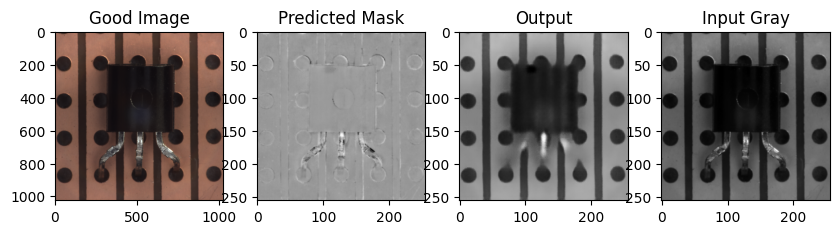

In [ ]:
path_good_pictures = "/content/drive/MyDrive/Dataset/transistor/test/good/000.png"

good_image = Image.open(path_good_pictures).convert("RGB")
good_gray  = Image.open(path_good_pictures).convert("L")

# Transformations
good_tensor = img_transform(good_image).unsqueeze(0).to(device)
good_gray_processed = img_transform(good_gray)
good_norm = good_gray_processed * 2 - 1

# Forward pass
model.eval()
with torch.no_grad():
    good_output = model(good_tensor)

# Compute predicted mask (error)
predicted_mask_good = good_output.squeeze().cpu().numpy() - good_norm.squeeze().cpu().numpy()

# -----------------------
# VISUALIZATION
# -----------------------
fig, ax = plt.subplots(1, 4, figsize=(10, 5))
ax[0].imshow(good_image)
ax[0].set_title("Good Image")
ax[1].imshow(predicted_mask_good, cmap="gray")
ax[1].set_title("Predicted Mask")
ax[2].imshow(good_output.squeeze().cpu().numpy(), cmap="gray")
ax[2].set_title("Output")
ax[3].imshow(good_gray_processed.squeeze().cpu().numpy(), cmap="gray")
ax[3].set_title("Input Gray")
plt.show()


In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/Dataset/weight_models/Def_Trans_2gen.pth")

# test